In [45]:
import tensorflow as tf

print(tf.keras.__version__)

2.5.0


In [46]:
import os
! git clone https://github.com/olafbar/classifiers.git


In [48]:
#########################################################################  
classifier='baseline'  #nazwa klasyfikatora
## baseline, baseline_knn, baseline_rf

dir='42'  # nazwa katalogu z obrazkami ANDROID (2 cyfry)
# url dla ANDROID
url='https://user.credo.science/user-interface/download/images/download.php?name='+dir+'.zip -O '+dir+'.zip'
#########################################################################
# dir='001'  # nazwa katalogu z obrazkami dla IOS (3 cyfry)
# #url dla IOS
# url='https://user.credo.science/user-interface/download/images_ios/download.php?name='+dir+'.zip -O '+dir+'.zip'

print(url)
os.system('wget %s' %url)
par=dir+' -d '+dir
os.system('unzip %s' %par)

https://user.credo.science/user-interface/download/images/download.php?name=26.zip -O 26.zip


0

In [49]:
import cv2
import glob
images=[]
list_images_name=[]
for img in glob.glob(dir+"/*.png"):
    n = cv2.imread(img)
    img = img.split('/')
    list_images_name.append(img[1])
    images.append(n)

In [50]:
def preprocessData(data, verbose=True):

  # import mahotas
  import numpy as np

  # print(wavelets)

  images = data

  features = []
  bl_images = []
  th_images = []

  for img in images:

    img = img.astype('int32')

    blackwhite=img[:,:,0]+img[:,:,1]+img[:,:,2]
    # bl_images.append(blackwhite.copy())

    threshold = blackwhite.mean() + blackwhite.std() * 5
    threshold = threshold if threshold < 100 else 100 

    mask = np.where(blackwhite > threshold, 1, 0)
    blackwhite = blackwhite * mask
    
    # feature #1
    num_pixels_over_th = np.sum(mask)

    # feature #2
    total_luminosity_over_th = np.sum(blackwhite)

    out = (num_pixels_over_th,total_luminosity_over_th)
    features.append(out)

  feature_array = np.array(features)

  if verbose:
    print(feature_array.shape)
    

  return (feature_array)


In [51]:
feature_array = preprocessData(data=(images))

(40000, 2)


In [52]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np

class BaseTrigger(BaseEstimator,ClassifierMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y):
#         compute minimal luminosity for artefacts and maximal luminosity for signals
#         compute minimal pix_count for artefacts and maximal pix_count for signals
        self.min_pixcount_arte_=X[:,0].max()
        self.min_lum_arte_=X[:,1].max()
        self.max_pixcount_sig_=X[:,0].min()
        self.max_lum_sig_=X[:,1].min()
        print("{} {} {} {}\n".format(self.min_pixcount_arte_,self.min_lum_arte_,self.max_pixcount_sig_,self.max_lum_sig_))
        for features,label in zip(X,y):
            pix_count=features[0,]
            lum=features[1,]
            if label==0 : #signal
                if pix_count>self.max_pixcount_sig_:
                    self.max_pixcount_sig_=pix_count
                if lum>self.max_lum_sig_:
                    self.max_lum_sig_=lum
            else:
                if pix_count<self.min_pixcount_arte_:
                    self.min_pixcount_arte_=pix_count
                if lum<self.min_lum_arte_:    
                    self.min_lum_arte_=lum
                    
        print("{} {} {} {}".format(self.min_pixcount_arte_,self.min_lum_arte_,self.max_pixcount_sig_,self.max_lum_sig_))    
        self.border_lum_=(self.min_lum_arte_+self.max_lum_sig_)/2
        self.border_pixcount_=(self.min_pixcount_arte_+self.max_pixcount_sig_)/2
        return self
    
    def predict(self, X):
        Y=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pix_count=X[i,0]
            # pix_count=0
            lum=X[i,1]
            if ((pix_count/self.border_pixcount_)**2+(lum/self.border_lum_)**2<=1):
                Y[i]=0
            else:    
                Y[i]=1
        return Y 
    
#     this method probably is not mandatory
#     def predict_proba(self, X):
#         pred = np.random.rand(X.shape[0], self.classes_.size)
#         return pred / np.sum(pred, axis=1)[:, np.newaxis]

In [53]:
#input=zip(feature_array, label_array)


In [54]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(BaseTrigger())

In [55]:
from joblib import dump, load
pkl_filename='classifiers/'+classifier+'.pkl'
# print(scaler_filename)
clf1=load(pkl_filename)


In [56]:
y_pred2 = clf1.predict(feature_array)

In [57]:
for i in range(2):
    count = sum(map(lambda x : x==i, y_pred2))
    print(i,count)

0 39610
1 390


In [58]:
classifiers=[classifier for x in range(len(y_pred2))]
import pandas as pd
df = pd.DataFrame({
    'Classifier': classifiers,
    'Hit ID': list_images_name,
    'Class': y_pred2
})

In [59]:
df.to_csv(classifier+'_'+dir+'.csv', index=False)

In [60]:
print(df.loc[df['Class'] == 0])

        Classifier        Hit ID  Class
0      baseline_rf  16065587.png      0
1      baseline_rf  10989912.png      0
2      baseline_rf   7511525.png      0
3      baseline_rf  13293418.png      0
4      baseline_rf  12791739.png      0
...            ...           ...    ...
39995  baseline_rf  12800355.png      0
39996  baseline_rf   9579108.png      0
39997  baseline_rf  16056679.png      0
39998  baseline_rf  10375094.png      0
39999  baseline_rf  10358282.png      0

[39610 rows x 3 columns]


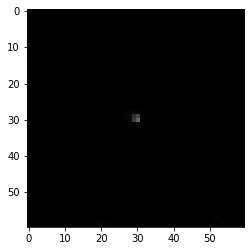

In [61]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(images[10])